In [1]:
import os
import tensorflow as tf
import numpy as np
import PIL
import matplotlib.pyplot as plt
from pathlib import Path

2022-03-31 11:26:58.790979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 11:26:58.790997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First, let's see the max number of tactile surfaces occur in a photo. This will define the size of the output vector because it will be the max number times 4 (for each bounding box coordinate) plus 1 (for number of bounding boxes in image).

In [2]:
max_annotations = 0

for image_label in os.listdir("../../data/trainval/label"):
    with open(os.path.join("../../data/trainval/label", image_label), "r") as f:
        for i, line in enumerate(f.readlines()):
            if i+1 > max_annotations:
                max_annotations = i+1

print(max_annotations)

4


In [3]:
max_image_width = 0
max_image_height = 0

for image_label in os.listdir("../../data/trainval/image"):
    if image_label.startswith("custom"):
        print(image_label)
        continue
    else:
        with PIL.Image.open(os.path.join("../../data/trainval/image", image_label)) as img:
            array = np.array(img)
            img.close()
        if array.shape[0] > max_image_width:
            max_image_width = array.shape[0]

        if array.shape[1] > max_image_height:
            max_image_height = array.shape[1]

print(max_image_width, max_image_height)

custom_train.json
768 1024


We need to resize the images so that they are all the same size. The method I am choosing is to find the largest image size and pad the rest with zeros. This way, it is easy to convert the bounding box coordinates to the correct coordinates on the padded image. Given an image, point coordinates $(x, y)$, and a padding distances $P_W, P_H$, the new coordinates are found by: 
$$
x \prime = x + \frac{P_W}{2}
\newline{}
\newline{}
y \prime = y + \frac{P_H}{2}
$$

**NOTE:** There are downsides to this method. First, if the kernel/filter sizes are small (3 by 3, 5 by 5, etc.), they will go over the padded region and do a lot of useless computations on the images that are padded. Second, the network might use the padded region as a feature but it is just black. I am choosing simplicity as a first pass and address it later if it is a problem. Fail fast and iterate quickly!

In [7]:
def parse_and_pad_image(filename: str) -> tf.Tensor:
    """Converts image path to a tensor, padded with zeros to the maximum image size in the dataset"""
    max_image_width = 1024
    max_image_height = 768

    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad( # problem: half of this padding needs
    # to be added to the x, y coords for the bounding boxes
        image, 
        target_height=max_image_height, 
        target_width=max_image_width
        )
    # image = tf.image.convert_image_dtype(image, tf.uint8)
    return image

In [8]:
def parse_image(filename):
    """Converts image path to a tensor"""
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image, channels=3)
    return image

In [9]:
def get_pad_dims(ds, padded_ds):
    """Gets difference between sizes of padded image and non-padded image"""
    h_pad_dims = []
    w_pad_dims = []

    for image, padded_image in zip(ds.take(-1), padded_ds.take(-1)):
        h_pad_dims.append(padded_image.shape[0] - image.shape[0])
        w_pad_dims.append(padded_image.shape[1] - image.shape[1])

    return h_pad_dims, w_pad_dims

In [58]:
def build_dataset(cloud:bool=False,train:bool=True) -> tf.data.Dataset:
    """
    Args:
        - cloud: data paths will change if I am running this locally vs on GCP. This parameter makes it easy to switch between the two
        - train: train or validation data
    """
    if cloud:
        data_dir = "data/"
    elif not cloud:
        data_dir = "../../data/"

    if train:
        data_path = data_dir + "trainval"
        path = Path(data_path)

    elif not train:
        data_path = data_dir + "test"
        path = Path(data_path)

    # IMAGES
    label_paths = sorted(map(str, (path / "label").glob('*.txt'))) # sort these so the labels match up with the images
    img_paths = sorted(map(str, (path / "image").glob('*.jpg')))

    list_ds = tf.data.Dataset.list_files(img_paths, shuffle=False)

    not_padded_ds = list_ds.map(parse_image)
    images_ds = list_ds.map(parse_and_pad_image)

    h_pad, w_pad = get_pad_dims(not_padded_ds, images_ds)

    # ANNOTATIONS
    targets = []
    j = 0 # counter to index into padding correction lists
    max_image_width = 1024
    max_image_height = 768

    for label in label_paths: # look at every image in path

        padding = (h_pad[j], w_pad[j])

        with open(label, "r") as f:
            unique_annotation = []
            for i, line in enumerate(f.readlines()):
                split_line = line.split(" ")

                image_class = split_line[0].strip()
                x1 = int(split_line[1].strip())
                y1 = int(split_line[2].strip())
                x2 = int(split_line[3].strip())
                y2 = int(split_line[4].strip("\n"))

                unique_annotation.append((float(x1 + int(padding[1]/2)))/ max_image_width)
                unique_annotation.append((float(y1 + int(padding[0]/2)))/ max_image_height)
                unique_annotation.append((float(x2 + int(padding[1]/2)))/ max_image_width)
                unique_annotation.append((float(y2 + int(padding[0]/2)))/ max_image_height)

        unique_annotation.insert(0, i+1) # insert number of bboxes

        while len(unique_annotation) < 17:
            unique_annotation.append(0) # pad with zeros if less than 3 bboxes
        
        # print(unique_annotation)
        targets.append(unique_annotation)

        j += 1

    targets = np.array([target for target in targets], dtype=float)
    target_ds = tf.data.Dataset.from_tensor_slices(targets)

    ds = tf.data.Dataset.zip((images_ds, target_ds))

    return ds

In [59]:
train_ds = build_dataset(cloud=False, train=True)

In [17]:
def visualize_example(example: tuple):
    max_image_width = 1024
    max_image_height = 768

    plt.figure(figsize=(16, 10))
    plt.imshow(tf.cast(example[0], tf.uint8))
    ax = plt.gca()
    plt.axis("off")

    # add in post processing: multiply x's by image width
    # and y's by image height

    bbox_1 = [coord.numpy() for coord in example[1][1:5]]
    bbox_2 = [coord.numpy() for coord in example[1][5:9]]
    bbox_3 = [coord.numpy() for coord in example[1][9:13]]
    bbox_4 = [coord.numpy() for coord in example[1][13:17]]

    boxes = [bbox_1, bbox_2, bbox_3, bbox_4]

    for box in boxes:
        ax.add_patch(plt.Rectangle(
            (box[0], box[1]), 
            box[2] - box[0], 
            box[3] - box[1],
            fill=False, color="red", linewidth=3
            )
        )

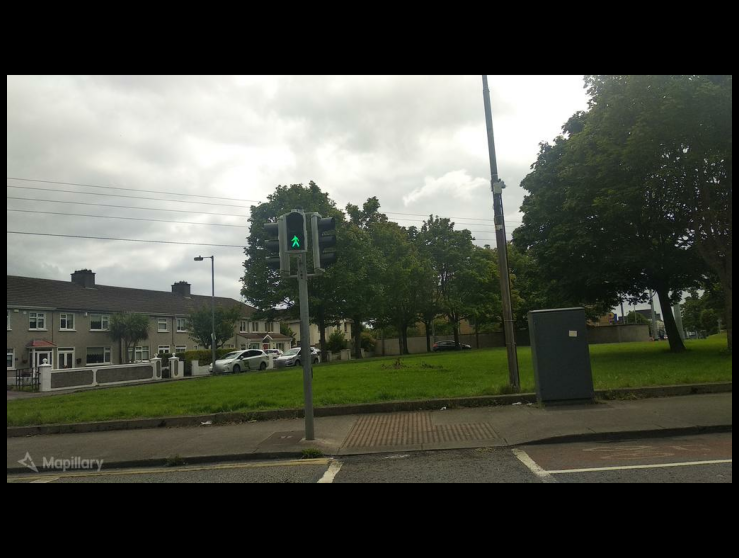

In [18]:
visualize_example(next(iter(ds.shuffle(16))))

# Model

In [19]:
import tensorflow.keras.layers as tfl
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [45]:
input_layer = tfl.Input(shape=[768, 1024, 3])
x = preprocess_input(input_layer)
pretrained_model = VGG16(include_top=False, weights="imagenet", input_tensor=x)(x)
additional_model = tfl.Flatten()(pretrained_model)
additional_model = tfl.Dense(25, activation="relu")(additional_model)
additional_model = tfl.Dense(17, activation="sigmoid")(additional_model) # outputs are normalized to (0, 1)
model = tf.keras.models.Model(inputs=input_layer, outputs=additional_model)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768, 1024, 3)]    0         
                                                                 
 tf.__operators__.getitem_1   (None, 768, 1024, 3)     0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 768, 1024, 3)     0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 24, 32, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 393216)            0         
                                                                 
 dense_2 (Dense)             (None, 25)                9830

In [46]:
model.layers[3].trainable = False

In [47]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768, 1024, 3)]    0         
                                                                 
 tf.__operators__.getitem_1   (None, 768, 1024, 3)     0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 768, 1024, 3)     0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 24, 32, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 393216)            0         
                                                                 
 dense_2 (Dense)             (None, 25)                9830

In [48]:
def loss_fn(y, y_hat):
    loss = 0.
    num_bboxes = y[0]

    loss = tf.reduce_sum(tf.square(tf.cast(y_hat, tf.float32) - tf.cast(y, tf.float32)))
    
    return loss

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [50]:
model.fit(ds.batch(2), epochs=1)

  9/901 [..............................] - ETA: 55:22 - loss: 0.3139 - root_mean_squared_error: 0.5603

KeyboardInterrupt: 